<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/index_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Linear Classification




In [9]:
!pip install demoji

In [10]:
! pip install alphabet-detector

In [11]:
!pip install googletrans==4.0.0rc1

## Imports

In [12]:
import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()
from googletrans import Translator

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

## Constants

In [14]:
TARGET_COLUMN = 'label'

## 1. Data Acquisition

In [15]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [16]:
training_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

In [17]:
dataset = pd.concat([training_data, test_data], axis=0) # Merge into one dataset for the pre-processing

In [18]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(training_data), len(test_data), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [19]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [20]:
dataset.head(10)

,tweet,label
0,El universo escribió que fueras para mi ^_^,es
1,@2_ssyy ههههههه,ar
2,Ya tus palabras poco me interesan.,es
3,@bubu_ quiilers n,pt
4,"Fútbol: La gran revelación de este Mundial, Co...",es
5,@Q63 お気をつけて。,ja
6,@ringo_ringo_17 セブン乗せてもらったことあるけど外国人受けもよさそうなのになああれ,ja
7,Ketika org yg pernah mnyakitimu disakiti oleh ...,id
8,武山、前の打席はカッコ悪かったから、今度は倍返し以上のええ働きをせんとアカン!!,ja
9,本当に悲しい…傷の舐め合いと優しさを勘違いしているし、本当の優しさは厳しいんです！飼い慣らさ...,ja


## 2. Data Exploration

In [21]:
def data_exploration(df, name=''):
    print('--- {} ---'.format(name))
    n_labels = len(np.unique(df["label"]))
    df = df.sort_values('label')
    print("{0} contains the columns: {1}".format(name, list(df.keys())))
    print("with a total of {} observations".format(len(df)))
    print("and {} different possible labels.".format(n_labels))
    print("The unique labels are {}".format(df["label"].unique()))
    plt.figure(figsize=(15, 3))
    plt.hist(df["label"], bins=n_labels)
    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.xlabel("Language")
    plt.ylabel("#Occurences")
    plt.show()

---  ---
 contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


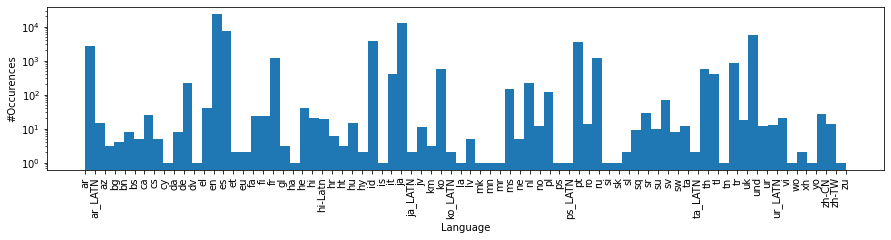

In [22]:
data_exploration(dataset, '')

## 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [23]:
def remove_all_emojis(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text

In [24]:
def  clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~！？。，、「」]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [25]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))

for language in languages:
    localized_tweets = training_data[training_data['label'] == language]
    # Clean and compare them
    cleaned_localized_tweets = clean_data(localized_tweets, 'tweet')
    comparison_view = pd.concat([localized_tweets.drop(['label'], axis=1), cleaned_localized_tweets], axis=1)
    print(comparison_view.head(5))
    #print(localized_tweets.head(5))
    print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                               tweet                                              tweet label
0  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...    ar
1  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...    ar
2  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...    ar
3                                  يا ابو سلو عرفتني                                  يا ابو سلو عرفتني    ar
4  ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...  ب ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل...    ar
---
                                         tweet                            tweet    label
2199                      ya allah ya allah x)              ya allah ya allah x  ar_LATN
2200                   Ya rab tekhlas hel game          ya rab tekhlas hel game  ar_LATN
2201                           Istaqfurullah 😂                   ista

In [26]:
cleaned_dataset = clean_data(dataset, "tweet")

In [27]:
pd.concat([dataset.drop(['label'], axis=1), cleaned_dataset], axis=1).sample(20, axis=0)

,tweet,tweet,label
47401,躊躇しまくって追加販売にも手を出せず、販売終了してからやっぱり買えば良かったーーー！！ってち...,躊躇しまくって追加販売にも手を出せず販売終了してからやっぱり買えば良かったーーーってちょう後...,ja
48520,@SLarramendi vos querida segui comiendo helado...,vos querida segui comiendo helado ya vas a ve...,es
48553,@LLeiteritz text meeeee,text meeeee,en
61349,"Y tiene un polvo, las cosas como son",y tiene un polvo las cosas como son,es
48031,@midnight #WorseMoonLandingQuotes Hey Buzz! Lo...,hey buzz look how high i can juuuumm whoa shiii,en
54705,Making kuih puteri mandi are just like making ...,making kuih puteri mandi are just like making ...,und
33364,Mind you it's 3 in the morning ! I almost piss...,mind you its in the morning i almost pissed ...,en
62117,#RetoTelehit #RetoTelehitJB #TelehitJB yo po...,yo porfavor yo quiero la guitarra de just...,es
65832,@Harry_whoranwat already done this one :)),already done this one,en
24992,@tomascogdill cuando usted desee,cuando usted desee,es


# 6.Feature Engineering


>**alphabet**: the detected alphabet in use 

>**character_count**: The number of character in each text observation.

>**word_count**: The the number of words in each text observation.

>**character_density**: The average characters per word. Divides the word_count by the character_count and creates an average relative relation between the latter two variables. This feature standardizes the length of a word based on how many words and characters there are in a text input.

>**punc_count**: Counts the number of punctuations in a text input. Some languages may use more punctuations.

>**num_consec_vowels**:Counts the number of consecutive vowels in a text.  
           
>**num_punctuation**: Counts the number of punctuations in a text. Some languages may use more punctuation.
                         
>**encode_ascii**: Checks whether a text can be encoded by utf-8

In [28]:
def detect_alphabet(df, column):
    df['alphabet'] = df[column].apply(lambda tweet: list(ad.detect_alphabet(tweet)))
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('alphabet')),
                            columns=mlb.classes_,
                            index=df.index))
    return df

In [29]:
dataset_w_alphabet = detect_alphabet(cleaned_dataset, 'tweet')
dataset_w_alphabet.head(30)

,tweet,label,ARABIC,ARMENIAN,BENGALI,BLACK-LETTER,BOPOMOFO,CANADIAN,CARON,CJK,CYRILLIC,DEVANAGARI,FEMININE,FULLWIDTH,GEORGIAN,GREEK,GUJARATI,GURMUKHI,HALFWIDTH,HANGUL,HEBREW,HIRAGANA,IDEOGRAPHIC,KANNADA,KATAKANA,KATAKANA-HIRAGANA,KHMER,LAO,LATIN,MASCULINE,MICRO,MODIFIER,ORIYA,SCRIPT,SINHALA,TAMIL,TELUGU,THAI,TIBETAN,YI
0,el universo escribió que fueras para mi,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,ههههههه,ar,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ya tus palabras poco me interesan,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,quiilers n,pt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,fútbol la gran revelación de este mundial cost...,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,お気をつけて,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,セブン乗せてもらったことあるけど外国人受けもよさそうなのになああれ,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,ketika org yg pernah mnyakitimu disakiti oleh ...,id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,武山前の打席はカッコ悪かったから今度は倍返し以上のええ働きをせんとアカン,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,本当に悲しい…傷の舐め合いと優しさを勘違いしているし本当の優しさは厳しいんです飼い慣らされた...,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df=dataset_w_alphabet

# character count
df['character_count'] = df['tweet'].apply(lambda x : len(x.replace(" ","")))
# word count
df['word_count'] = df['tweet'].apply(lambda x : len(x.split()))

# character density: average character per word
df['character_density'] = round(df['word_count'] / df['character_count'], 3)

# punctuation count
df['punc_count'] = df['tweet'].apply(lambda x : x.count(' '))

# num_consec_vowels
from itertools import permutations
vowels=['a','e','i','o','u']
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
df['num_consec_vowels'] = df['tweet'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))

# check if the text can be encoded by utf-8
df['encode_ascii'] = np.nan
for i in range(len(df)):
    try:
        df['tweet'].iloc[i].encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        df['encode_ascii'].iloc[i] = 0
    else:
        df['encode_ascii'].iloc[i] = 1

        

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [31]:
df.head(30)

,tweet,label,ARABIC,ARMENIAN,BENGALI,BLACK-LETTER,BOPOMOFO,CANADIAN,CARON,CJK,CYRILLIC,DEVANAGARI,FEMININE,FULLWIDTH,GEORGIAN,GREEK,GUJARATI,GURMUKHI,HALFWIDTH,HANGUL,HEBREW,HIRAGANA,IDEOGRAPHIC,KANNADA,KATAKANA,KATAKANA-HIRAGANA,KHMER,LAO,LATIN,MASCULINE,MICRO,MODIFIER,ORIYA,SCRIPT,SINHALA,TAMIL,TELUGU,THAI,TIBETAN,YI,character_count,word_count,character_density,punc_count,num_consec_vowels,encode_ascii
0,el universo escribió que fueras para mi,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,33,7,0.212,7,2,0.0
1,ههههههه,ar,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0.143,3,0,0.0
2,ya tus palabras poco me interesan,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,28,6,0.214,5,0,1.0
3,quiilers n,pt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,2,0.222,2,1,1.0
4,fútbol la gran revelación de este mundial cost...,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,44,9,0.205,9,1,0.0
5,お気をつけて,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0.167,1,0,0.0
6,セブン乗せてもらったことあるけど外国人受けもよさそうなのになああれ,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,1,0.030,1,0,0.0
7,ketika org yg pernah mnyakitimu disakiti oleh ...,id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,92,16,0.174,16,2,1.0
8,武山前の打席はカッコ悪かったから今度は倍返し以上のええ働きをせんとアカン,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,1,0.028,0,0,0.0
9,本当に悲しい…傷の舐め合いと優しさを勘違いしているし本当の優しさは厳しいんです飼い慣らされた...,ja,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,106,1,0.009,0,0,0.0


# 7.Modeling 

In [32]:
def train_val_test_split(X, y, test_size=0.3, val_size=0.1): #90/10 split for trainning and development set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
df.isnull().values.any()

True

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65954 entries, 0 to 65953
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet              65954 non-null  object 
 1   label              65954 non-null  object 
 2   ARABIC             65954 non-null  int64  
 3   ARMENIAN           65954 non-null  int64  
 4   BENGALI            65954 non-null  int64  
 5   BLACK-LETTER       65954 non-null  int64  
 6   BOPOMOFO           65954 non-null  int64  
 7   CANADIAN           65954 non-null  int64  
 8   CARON              65954 non-null  int64  
 9   CJK                65954 non-null  int64  
 10  CYRILLIC           65954 non-null  int64  
 11  DEVANAGARI         65954 non-null  int64  
 12  FEMININE           65954 non-null  int64  
 13  FULLWIDTH          65954 non-null  int64  
 14  GEORGIAN           65954 non-null  int64  
 15  GREEK              65954 non-null  int64  
 16  GUJARATI           659

In [35]:
df=df.dropna(axis=0,how='any')

In [36]:
df.isnull().values.any()

False

In [37]:
X = df.drop([TARGET_COLUMN, 'tweet'], axis=1)
y = df[TARGET_COLUMN]
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

In [47]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(max_iter=3000, tol=0.01, verbose=True)
sgdc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 340.04, NNZs: 27, Bias: -248.366394, T: 44554, Avg. loss: 138.668925
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 263.26, NNZs: 29, Bias: -217.829567, T: 89108, Avg. loss: 19.762563
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 214.81, NNZs: 30, Bias: -198.090594, T: 133662, Avg. loss: 4.413977
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 190.23, NNZs: 30, Bias: -181.271462, T: 178216, Avg. loss: 6.657087
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 175.87, NNZs: 31, Bias: -165.419347, T: 222770, Avg. loss: 5.347333
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 161.20, NNZs: 31, Bias: -154.788211, T: 267324, Avg. loss: 5.616669
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 151.16, NNZs: 31, Bias: -145.199169, T: 311878, Avg. loss: 4.640924
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 142.78, NNZs: 31, Bias: -137.336467, T: 356432, Avg. loss: 3.216233
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 133.81, NNZs: 31, Bias

[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   11.5s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=3000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [48]:
score = sgdc.score(X_train, y_train)
print("Accuracy score.: ", score)

Accuracy score.:  0.4582529065852673


In [49]:
np.set_printoptions(threshold=100)

#prediting
y_pred = sgdc.predict(X_test)

In [50]:
confusion_matrix(y_test, y_pred)

array([[528,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [51]:
cr = classification_report(y_test, y_pred)
print(cr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          ar       0.98      0.70      0.82       756
     ar_LATN       0.00      0.00      0.00         5
          bn       0.00      0.00      0.00         2
          bs       0.00      0.00      0.00         3
          ca       0.00      0.00      0.00        10
          cs       0.00      0.00      0.00         1
          da       0.00      0.00      0.00         3
          de       0.00      0.00      0.00        70
          el       0.00      0.00      0.00        14
          en       0.76      0.15      0.25      6276
          es       0.26      0.56      0.36      2005
          fa       0.00      0.00      0.00         9
          fi       0.00      0.00      0.00         6
          fr       0.14      0.01      0.02       306
          he       1.00      0.70      0.82        10
          hi       0.00      0.00      0.00         3
     hi-Latn       0.00      0.00      0.00         4
          hr       0.00    

# 8.Evaluation

As it is shown in the above confusion metrix, our model performs well in languages with larger datasets and unique alphabets, such as English, Japanese, Hebrew, Russian, etc. Meanwhile this model performs less effective in the classification of languages with fewer data. The overall precision and recall are around 50%.